# Teaching a Deep Convolutional Generative Adversarial Network (DCGAN) to draw MNIST characters

In the last tutorial, we learnt using tensorflow for designing a Variational Autoencoder (VAE) that could draw MNIST characters. Most of the created digits looked nice. There was only one drawback -- some of the created images looked a bit fuzzy. The VAE was trained with the _mean squared error_ loss function. However, it's quite difficult to encode exact character edge locations, which leads to the network being unsure about those edges. And does it really matter if the edge of a character starts a few pixels more to the left or right? Not really.
In this article, we will see how we can train a network that does not depend on the mean squared error or any related loss functions--instead, it will learn all by itself what a real image should look like.

## Deep Convolutional Generative Adversarial Networks
Another network architecture for learning to generate new content is the DCGAN. Like the VAE, our DCGAN consists of two parts:
* The _discriminator_ learns how to distinguish fake from real objects of the type we'd like to create
* The _generator_ creates new content and tries to fool the discriminator

There is a HackerNoon article by Chanchana Sornsoontorn that explains the concept in more detail and describes some creative projects DCGANs have been applied to. One of these projects is the generation of MNIST characters. Let's try to use python and tensorflow for the same purpose.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Code by Parag Mital (github.com/pkmital/CADL)
def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

## Setting up the basics
Like in the last tutorial, we use tensorflow's own method for accessing batches of MNIST characters. We set our batch size to be 64. Our generator will take noise as input. The number of these inputs is being set to 100. Batch normalization considerably improved the training of this network. For tensorflow to apply batch normalization, we need to let it know whether we are in training mode. The variable _keep_prob_ will be used by our dropout layers, which we introduce for more stable learning outcomes.
_lrelu_ defines the popular leaky ReLU, that hopefully will be supported by future versions of tensorflow! I firstly tried to apply standard ReLUs to this network, but this lead to the well-known _dying ReLU problem_, and I received generated images that looked like artwork by Kazimir Malevich--I just got black squares. 

Then, we define a function _binary_cross_entropy_, which we will use later, when computing losses.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
tf.reset_default_graph()
batch_size = 64
n_noise = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## The discriminator
Now, we can define the discriminator. It looks similar to the encoder part of our VAE. As input, it takes real or fake MNIST digits (28 x 28 pixel grayscale images) and applies a series of convolutions. Finally, we use a sigmoid to make sure our output can be interpreted as the probability to that the input image is a real MNIST character.

In [4]:
def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

## The generator
The generator--just like the decoder part in our VAE--takes noise and tries to learn how to transform this noise into digits. To this end, it applies several transpose convolutions. At first, I didn't apply batch normalization to the generator, and its learning seemed to be really unefficient. After applying batch normalization layers, learning improved considerably. Also, I firstly had a much larger dense layer accepting the generator input. This led to the generator creating the same output always, no matter what the input noise was. Tuning the generator honestly took quite some effort!

In [5]:
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x    

## Loss functions and optimizers
Now, we wire both parts together, like we did for the encoder and the decoder of our VAE in the last tutorial.
However, we have to create two objects of our discriminator
* The first object receives the real images
* The second object receives the fake images

_reuse_ of the second object is set to _True_ so both objects share their variables. We need both instances for computing two types of losses:
* when receiving real images, the discriminator should learn to compute high values (near _1_), meaning that it is confident the input images are real
* when receiving fake images, it should compute low values (near _0_), meaning it is confident the input images are not real

To accomplish this, we use the _binary cross entropy_ function defined earlier. The generator tries to achieve the opposite goal, it tries to make the discriminator assign high values to fake images.

Now, we also apply some regularization. We create two distinct optimizers, one for the discriminator, one for the generator. We have to define which variables we allow these optimizers to modify, otherwise the generator's optimizer could just mess up the discriminator's variables and vice-versa.

We have to provide the __update_ops__ to our optimizers when applying batch normalization--take a look at the tensorflow documentation for more information on this topic.

In [6]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training the DCGAN
Finally, the fun part begins--let's train our network! 
We feed random values to our generator, which will learn to create digits out of this noise. We also take care that neither the generator nor the discriminator becomes too strong--otherwise, this would inhibit the learning of the other part and could even stop the network from learning anything at all (I unfortunately have made this experience).

0 0.6940762 0.68833303 0.6901132 0.69803923


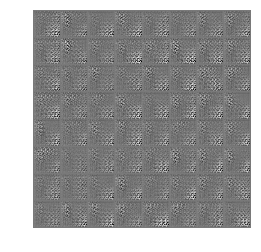

50 0.6790165 0.71922004 0.6902498 0.66778326


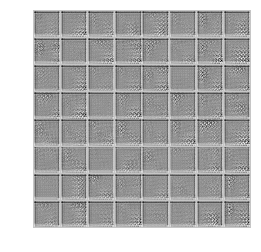

100 0.54612136 1.0844697 0.66815084 0.42409202


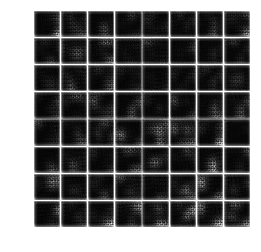

150 0.47391343 0.9905808 0.44221255 0.5056142
not training discriminator


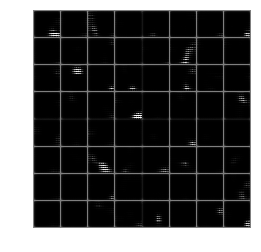

200 0.49220118 1.1140236 0.5286443 0.45575806
not training discriminator


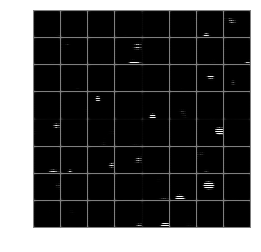

250 0.52257526 1.1500175 0.5579623 0.48718828
not training discriminator


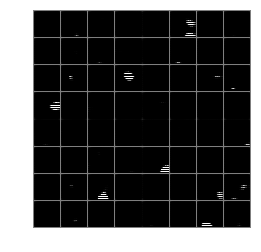

300 0.5946373 1.2879362 0.7725651 0.41670942
not training discriminator


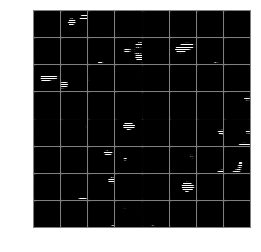

350 0.68920696 1.5787889 1.0765424 0.30187157
not training discriminator


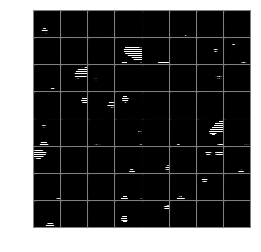

KeyboardInterrupt: 

In [7]:
for i in range(60000):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]  
    
    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
    
    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 50:
        print (i, d_ls, g_ls, d_real_ls, d_fake_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,0] for img in gen_img]
        m = montage(imgs)
        gen_img = m
        plt.axis('off')
        plt.imshow(gen_img, cmap='gray')
        plt.show()

## Results
Take a look at the pictures drawn by our generator--they look more realistic than the pictures drawn by the VAE, which looked more fuzzy at their edges. Training however took much longer than training the other model.

In conclusion, training the DCGAN took me much longer than training the VAE. Maybe fine-tuning the architecture could speed up the network's learning. Nonetheless, it's a real advantage that we are not dependent on loss functions based on pixel positions, making the results look less fuzzy. This is especially important when creating more complex data--e.g. pictures of human faces. So, just be a little patient--then everything is possible in the world of deep learning!